# Feature Importance


## Einlesen von Packages und setzen von Variablen / Funktionen

In [1]:
import sys
import os

parentdir = os.path.dirname(os.path.abspath(''))
sys.path.append(parentdir)

from datetime import date

import pandas as pd
import numpy as np

import pandas_profiling as pd_profil

import functions as fu
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


%matplotlib inline

# Pfade setzen
c_fold = fu.get_folder()
p_fold = c_fold + '\data\Prepared'
folder = c_fold + '\data\Processed\Zyklus'
folder_final = c_fold + '\data\Processed\\final'

# y = df.loc[:, df.columns.isin(['amperestunden'])]
# X = df.loc[:, ~df.columns.isin(['amperestunden'])]

## Daten einlesen und erste Übersicht erzeugen

In [2]:
daten = pd.read_csv(f"{folder_final}\\df_fertige_features_ref_discharge.csv", sep=',')
daten.drop(["batteryname_","comment_","type_"], axis=1, inplace=True) #brauch ich hier nicht
daten.drop(["time_amin"], axis=1, inplace=True) #zu viel überschneidung mit *_leicht_vorher
daten = daten[daten["amperestunden"] != 0] #nicht logisch

In [3]:
daten.head(1)

,amperestunden,zyklus_,temperature_amax,temperature_amin,temperature_mean,time_entladen_stark_vorher,time_entladen_leicht_vorher,time_laden_stark_vorher,time_laden_leicht_vorher,time_pause_vorher,time_temp_hoch_vorher
0,2.000364,3,23.56742,18.39025,21.798768,0.0,196178.5,0.0,194718.28,0.0,0.0


In [4]:
daten.describe().T

,count,mean,std,min,25%,50%,75%,max
amperestunden,947.0,1.506245e+00,3.221559e-01,0.692978,1.255331e+00,1.493948e+00,1.755298e+00,2.147193e+00
zyklus_,947.0,2.829791e+04,2.833194e+04,1.000000,8.086000e+03,1.607700e+04,3.956050e+04,1.135760e+05
temperature_amax,947.0,-3.399548e+02,1.179261e+03,-4099.447750,2.464716e+01,2.705890e+01,3.433525e+01,4.493351e+01
temperature_amin,947.0,-3.661795e+02,1.208497e+03,-4099.447750,1.948165e+01,2.180372e+01,2.856643e+01,4.065417e+01
temperature_mean,947.0,-3.596099e+02,1.202247e+03,-4099.447750,2.231664e+01,2.449171e+01,3.169589e+01,4.214114e+01
time_entladen_stark_vorher,947.0,2.054629e+05,1.234425e+05,0.000000,1.242027e+05,2.035827e+05,2.643333e+05,5.931812e+05
time_entladen_leicht_vorher,947.0,1.362207e+06,1.093917e+06,7538.120000,4.738886e+05,1.107009e+06,1.898047e+06,4.347433e+06
time_laden_stark_vorher,947.0,4.768020e+04,7.710116e+04,0.000000,0.000000e+00,0.000000e+00,9.855867e+04,2.416744e+05
time_laden_leicht_vorher,947.0,3.660426e+06,2.466431e+06,1627.080000,1.689898e+06,3.402548e+06,5.029218e+06,1.085041e+07
time_pause_vorher,947.0,1.052630e+06,1.184730e+06,0.000000,1.285892e+05,6.499665e+05,1.505293e+06,5.585429e+06


Saving figure features_histogram_plots


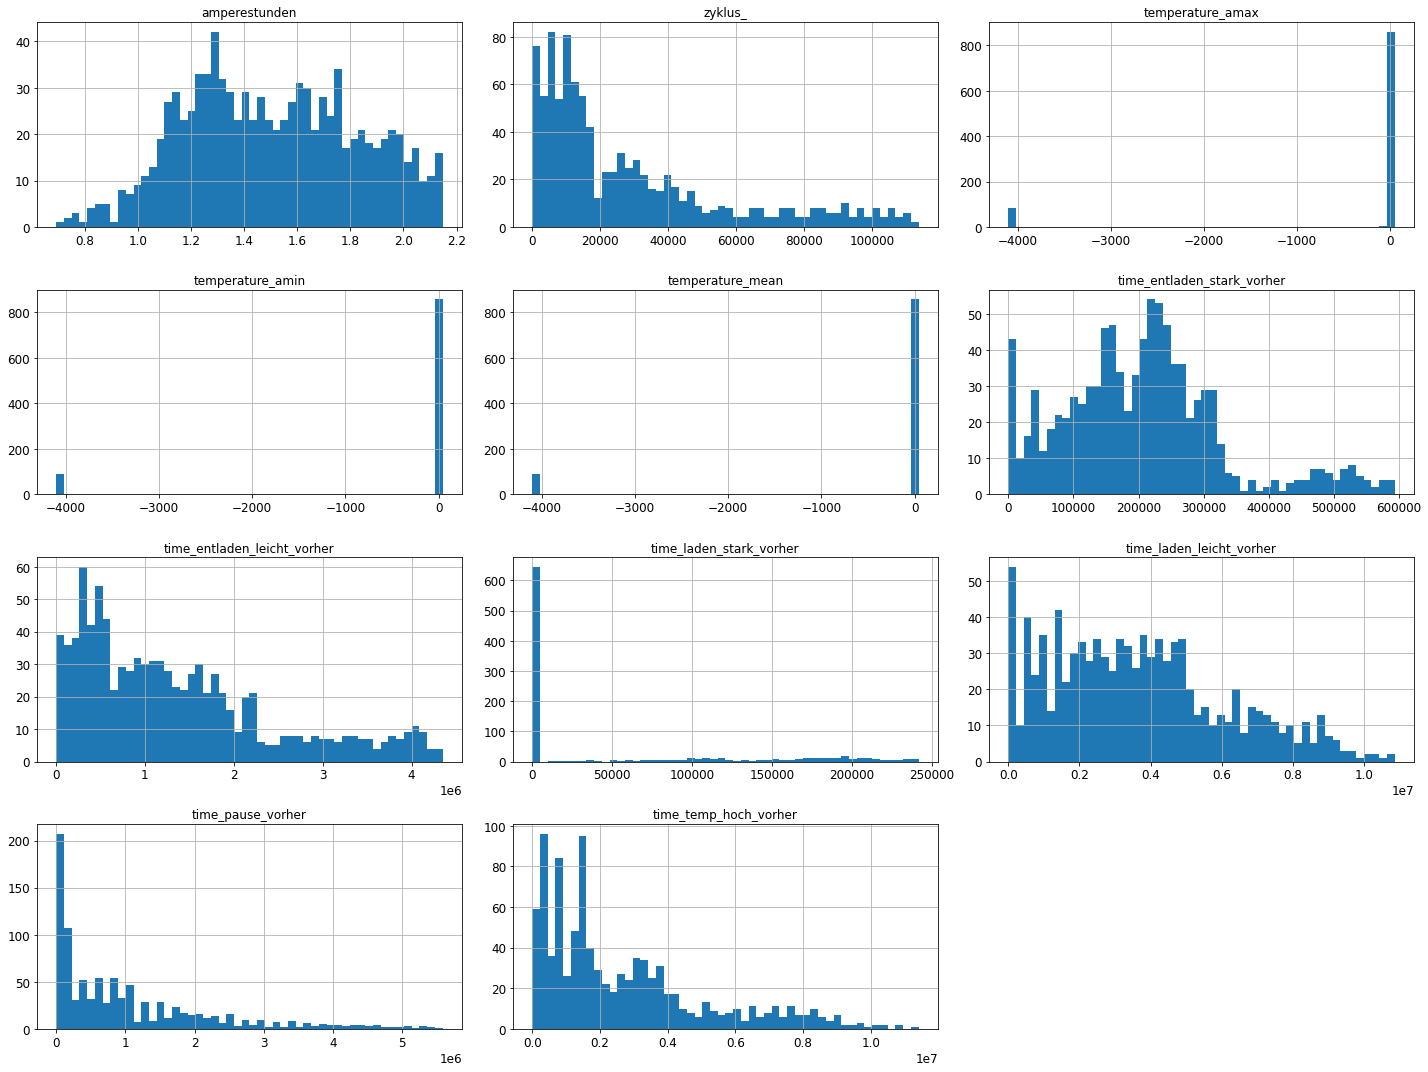

In [5]:
daten.hist(bins=50, figsize=(20,15))
fu.save_fig("features_histogram_plots")
plt.show()

# Ausreißer

* Temperatur hat Ausreißer in die -4000° Region. Die Werte sollten ersetzt werden durch den Median des Rests
* Es scheint die Werte unterhalb des 10% Percentils zu betreffen

In [6]:
daten[["temperature_amax","temperature_amin",'temperature_mean']].describe(percentiles=[.01, .05, .06, .07, .08, .09, .10, .25]).T

,count,mean,std,min,1%,5%,6%,7%,8%,9%,10%,25%,50%,max
temperature_amax,947.0,-339.954836,1179.260792,-4099.44775,-4094.09814,-4093.927,-4093.927,-4093.927,-4093.927,-69.120329,23.066152,24.647160,27.058900,44.933510
temperature_amin,947.0,-366.179536,1208.497383,-4099.44775,-4094.09814,-4093.927,-4093.927,-4093.927,-4093.927,-4093.927000,17.546158,19.481645,21.803720,40.654170
temperature_mean,947.0,-359.609921,1202.246988,-4099.44775,-4094.09814,-4093.927,-4093.927,-4093.927,-4093.927,-4056.380986,20.811553,22.316639,24.491707,42.141144


In [7]:
daten_ohne_aus = daten.copy()
spalten_mit_ausreißern = ["temperature_amax","temperature_amin",'temperature_mean']
for spalte in spalten_mit_ausreißern:
    neuer_wert = daten_ohne_aus[daten_ohne_aus[spalte] > np.percentile(daten_ohne_aus[spalte],10)][spalte].median() #ersetzen durch den Median der Restwerte
    daten_ohne_aus.loc[daten_ohne_aus[spalte] < np.percentile(daten_ohne_aus[spalte],10),spalte] = neuer_wert #neuen Wert setzen


In [8]:
daten_ohne_aus[["temperature_amax","temperature_amin",'temperature_mean']].describe(percentiles=[.01, .05, .06, .07, .08, .09, .10, .25]).T

,count,mean,std,min,1%,5%,6%,7%,8%,9%,10%,25%,50%,max
temperature_amax,947.0,30.352861,6.099227,23.159540,23.392825,23.915035,24.041195,24.112383,24.205488,24.264600,24.314476,25.619230,27.842150,44.933510
temperature_amin,947.0,25.004356,6.276055,17.555590,17.854556,18.535666,18.694734,18.822713,18.870574,19.009958,19.068174,20.202750,22.481255,40.654170
temperature_mean,947.0,27.929223,6.125406,20.839432,21.031769,21.695376,21.768601,21.819724,21.865467,21.930856,22.010801,23.161608,25.427230,42.141144


Saving figure features_histogram_plots_ohne_ausreißer


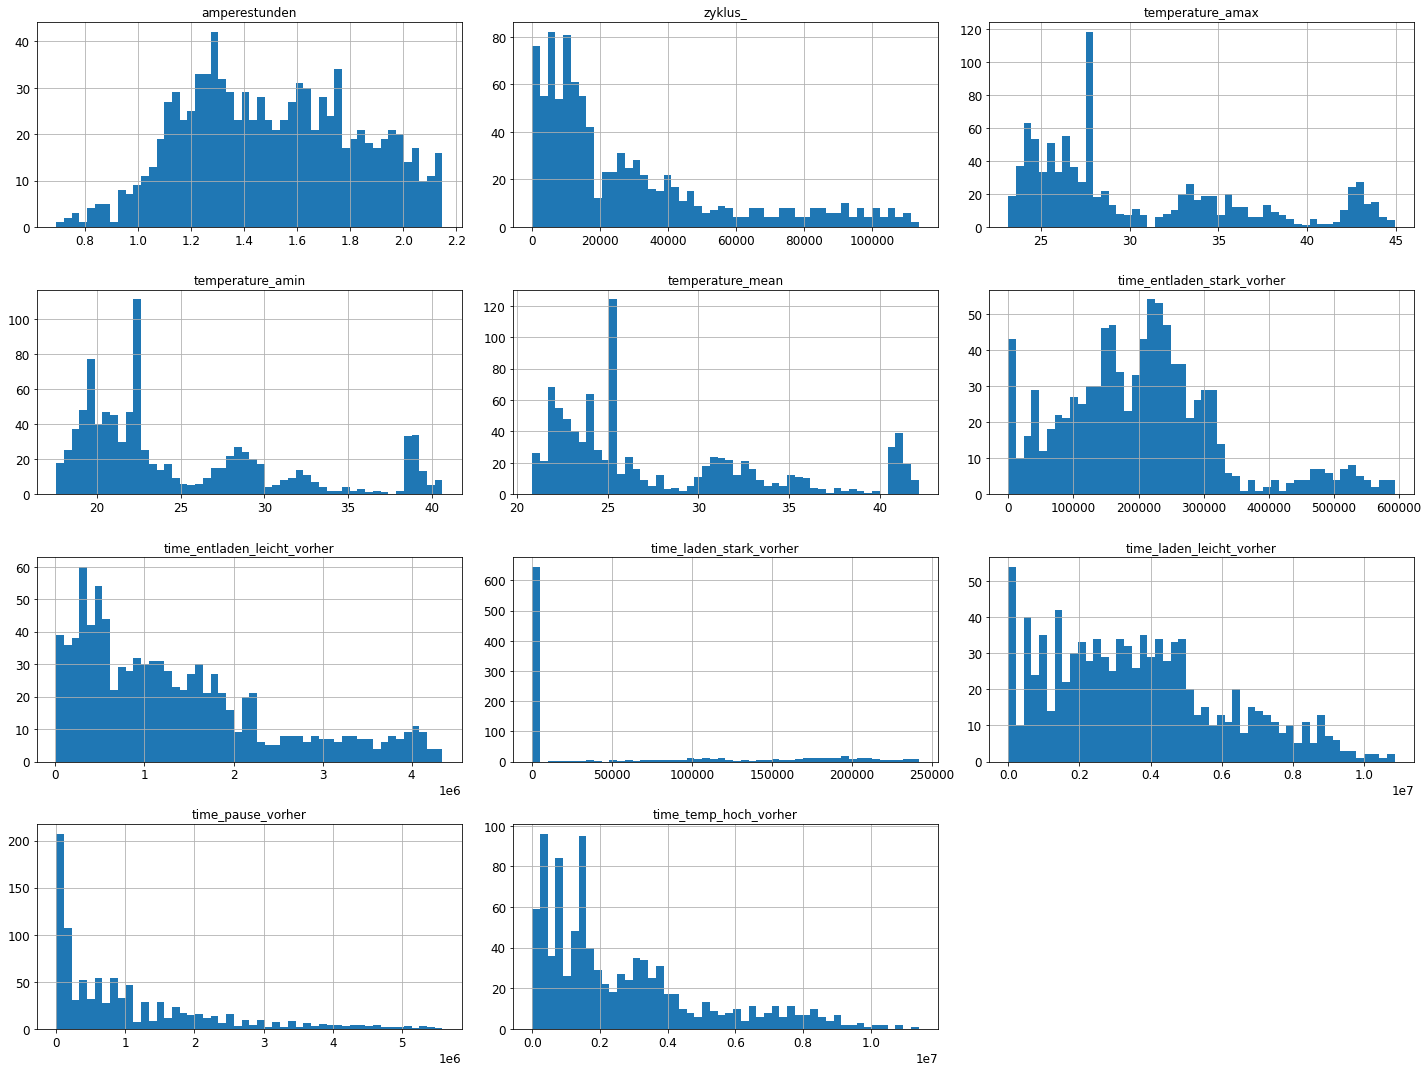

In [9]:
daten_ohne_aus.hist(bins=50, figsize=(20,15))
fu.save_fig("features_histogram_plots_ohne_ausreißer")
plt.show()

# Modellierung des Machine Learnings

## Korrelationen mit "amperestunden"
Welche der Features korrellieren am meisten mit der Zielvariablen? Wie schneiden die neu generierten Features ab? 

Saving figure features_korrelationen_mit_amperestunden


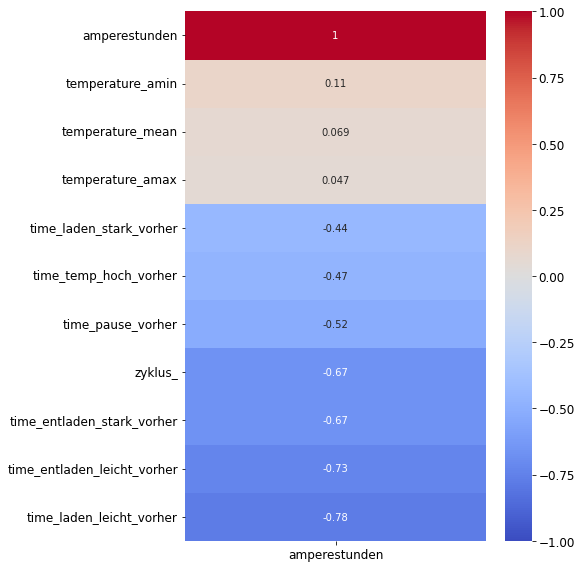

In [10]:
correlation = daten_ohne_aus.corr()
plt.figure(figsize=(8,8))
sns.heatmap(correlation[["amperestunden"]].sort_values(by=['amperestunden'], ascending=False), vmin=-1, cmap='coolwarm', annot=True)
fu.save_fig("features_korrelationen_mit_amperestunden")

# Train Test Split

In [11]:
train_set, test_set = train_test_split(daten_ohne_aus, test_size=0.2, random_state=42)

daten = train_set.drop("amperestunden", axis=1)
daten_labels = train_set["amperestunden"].copy()


test_daten = train_set.drop("amperestunden", axis=1)
test_daten_labels = train_set["amperestunden"].copy()

# Null Werte -> Keine

Saving figure null_werte_in_daten


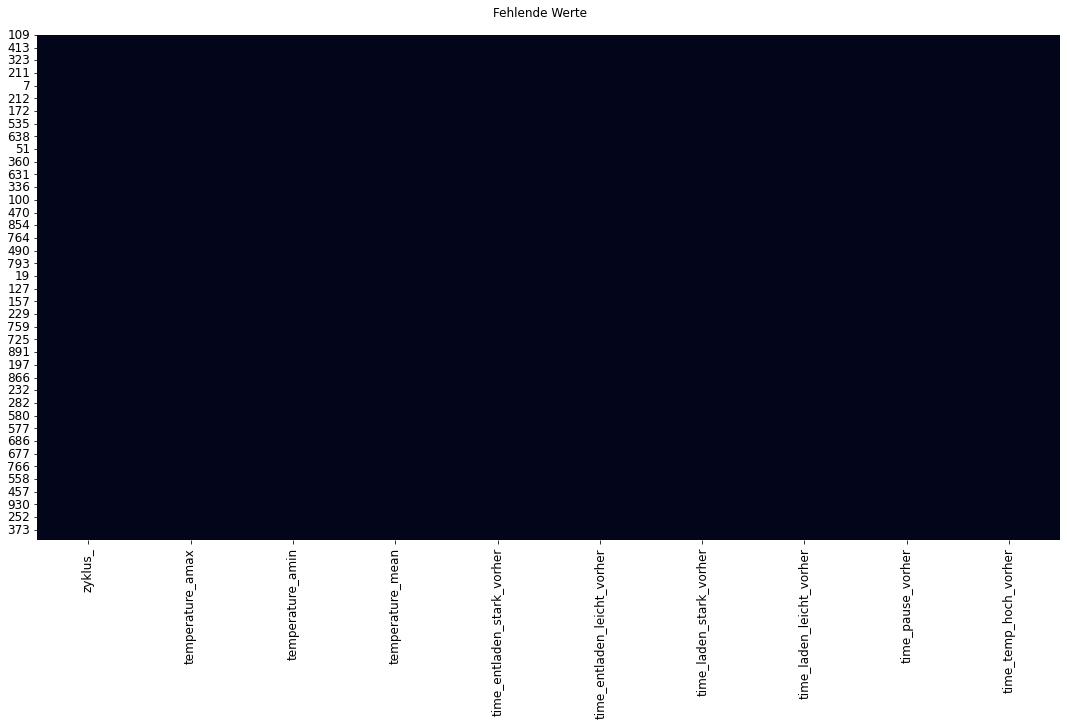

In [12]:
fig, axes = plt.subplots(1, figsize=(15, 8), sharey = False)
fig.suptitle('Fehlende Werte')
fu.save_fig("null_werte_in_daten")

sns.heatmap( data = daten.isnull(), cbar = False)
plt.draw()

# Transform-Pipeline

In [14]:
num_pipeline = Pipeline([
('std_scaler', StandardScaler()), #Warum Standard Scaler? keine Normalverteilung in den Daten
])

num_attribs = list(daten.columns)

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs)
    ])

daten_tr = full_pipeline.fit_transform(daten)

# Hyperparameter - beste Suchen mit RandomizedSearchCV

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
rfr_pm     = RandomForestRegressor()

params = {'n_estimators': range(100,1500),
          'n_jobs':       [-1],
          'criterion':    ['squared_error','absolute_error'],
          'max_depth':    range(1,200)
         }
k      = 3

reg_search = RandomizedSearchCV(rfr_pm, params, scoring= 'neg_root_mean_squared_error', cv = k, verbose = 1, n_iter=200)

In [16]:
%%time
reg_search.fit(daten_tr, daten_labels)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Wall time: 13min 30s


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=200,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': range(1, 200),
                                        'n_estimators': range(100, 1500),
                                        'n_jobs': [-1]},
                   scoring='neg_root_mean_squared_error', verbose=1)

In [17]:
print(reg_search.best_params_)

{'n_jobs': -1, 'n_estimators': 452, 'max_depth': 115, 'criterion': 'absolute_error'}


In [18]:
pd.DataFrame(reg_search.cv_results_).sort_values(by = ['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_jobs,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
155,0.989595,0.019508,0.073157,0.002589,-1,452,115,absolute_error,"{'n_jobs': -1, 'n_estimators': 452, 'max_depth...",-0.058726,-0.051302,-0.050125,-0.053384,0.003808,1
46,2.635668,0.022442,0.178169,0.008209,-1,1266,56,absolute_error,"{'n_jobs': -1, 'n_estimators': 1266, 'max_dept...",-0.058717,-0.051304,-0.050145,-0.053389,0.003797,2
61,2.999519,0.069219,0.198859,0.002785,-1,1433,139,absolute_error,"{'n_jobs': -1, 'n_estimators': 1433, 'max_dept...",-0.058692,-0.051158,-0.050324,-0.053391,0.003764,3
106,0.153753,0.015964,0.021207,0.001893,-1,118,117,squared_error,"{'n_jobs': -1, 'n_estimators': 118, 'max_depth...",-0.057356,-0.051239,-0.051598,-0.053397,0.002803,4
161,0.990789,0.005250,0.072021,0.005489,-1,447,147,absolute_error,"{'n_jobs': -1, 'n_estimators': 447, 'max_depth...",-0.058837,-0.050817,-0.050615,-0.053423,0.003829,5


# bestes Modell wegschreiben

In [19]:
prepare_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('rfr_reg', reg_search.best_estimator_)
])

In [20]:
import joblib
joblib.dump(prepare_and_predict_pipeline, "pickle/prepare_and_predict_pipeline.pkl")

['pickle/prepare_and_predict_pipeline.pkl']

In [16]:
import joblib
prepare_and_predict_pipeline_load = joblib.load("pickle/prepare_and_predict_pipeline.pkl")

# Vorhersage Test-Daten

In [17]:
test_daten_pred = prepare_and_predict_pipeline_load.predict(test_daten)
test_daten_pred_series = pd.Series(test_daten_pred, index=test_daten_labels.index)

Saving figure vergleich_rfr_prediction_mit_tatsächlichen_werten


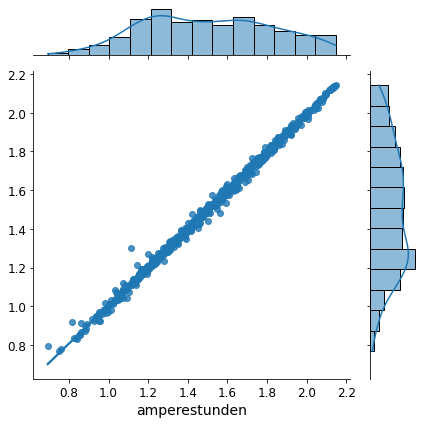

In [18]:
sns.jointplot(x=test_daten_labels,y=test_daten_pred_series, kind='reg')
fu.save_fig("vergleich_rfr_prediction_mit_tatsächlichen_werten")

In [19]:
from sklearn import metrics
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_daten_labels, test_daten_pred_series)))
print('R2:',metrics.r2_score(test_daten_labels, test_daten_pred_series))

RMSE: 0.017313937671897334
R2: 0.9971082880610206


# Wichtigkeit Features

In [25]:
sorted(zip(reg_search.best_estimator_.feature_importances_, daten.columns), reverse=True)

[(0.2776744840907763, 'time_entladen_stark_vorher'),
 (0.25822242760700315, 'time_laden_leicht_vorher'),
 (0.23428305218310297, 'time_entladen_leicht_vorher'),
 (0.06074659963813213, 'zyklus_'),
 (0.055468040335308125, 'time_pause_vorher'),
 (0.04335285364322549, 'time_temp_hoch_vorher'),
 (0.0216060353039273, 'time_laden_stark_vorher'),
 (0.019362217937416628, 'temperature_amin'),
 (0.014994219881302116, 'temperature_amax'),
 (0.014290069379805788, 'temperature_mean')]

# Ent-/Laden und Anzahl an Wechsel sind wichtig

Sowohl in der Korrelation und von dem RFR werden die folgenden 5 Featrues als Wichtig angesehen:
* time_laden_leicht_vorher
* time_laden_stark_vorher
* time_entladen_leicht_vorher
* time_entladen_stark_vorher
* zyklus_

## offene Frage: Wie groß ist der Einfluss auf die Amperestunden? Um wie viel sinken die Amperestunden bei einer Minute der unterschiedlichen Verwendungen? Um wie viel ein Wechsel der Verwendung?
#### dies kann mit einer klassischen Regression nur mit den richtigen Features und den zugehörigen Regressionskoeffizienten bestimmt werden:

In [29]:
from sklearn.linear_model import LinearRegression   



ss = StandardScaler()
daten_lr = ss.fit_transform(daten[["time_temp_hoch_vorher","time_laden_leicht_vorher","time_laden_stark_vorher","time_entladen_leicht_vorher","time_entladen_stark_vorher","zyklus_"]]) 
 
lr = LinearRegression()  
 
lr.fit(daten_lr, daten_labels)

LinearRegression()

In [34]:
coefs = pd.DataFrame(zip(daten[["time_temp_hoch_vorher","time_laden_leicht_vorher","time_laden_stark_vorher","time_entladen_leicht_vorher","time_entladen_stark_vorher","zyklus_"]].columns, lr.coef_ * np.sqrt(ss.var_) + ss.mean_), columns=["feature","wert"])
coefs.set_index('feature', inplace=True)
coefs

,wert
feature,
time_temp_hoch_vorher,2.638642e+06
time_laden_leicht_vorher,3.078875e+06
time_laden_stark_vorher,3.832648e+04
time_entladen_leicht_vorher,1.271029e+06
time_entladen_stark_vorher,2.051081e+05
zyklus_,2.916915e+04


### Wie viele Stunden in welcher Benutzung um die Amperestunden um 1 zu reduzieren?

In [35]:
zeit_coefs = coefs.loc[["time_temp_hoch_vorher","time_laden_leicht_vorher","time_laden_stark_vorher","time_entladen_leicht_vorher","time_entladen_stark_vorher"],["wert"]]

In [37]:
zeit_coefs["wert"] / 3600

feature
time_temp_hoch_vorher          732.956234
time_laden_leicht_vorher       855.243129
time_laden_stark_vorher         10.646244
time_entladen_leicht_vorher    353.063737
time_entladen_stark_vorher      56.974479
Name: wert, dtype: float64

### Wie viele Benutzungswechsel um die Amperestunden um 1 zu reduzieren?

In [38]:
zyk_coef = coefs.loc[["zyklus_"],["wert"]]
zyk_coef["wert"] 

feature
zyklus_    29169.150846
Name: wert, dtype: float64